In [210]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot


from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

import optuna
import xgboost as xgb

import warnings
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter('ignore', pd.errors.SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=pd.errors.PerformanceWarning)


In [211]:
train_wOrdinal = pd.read_csv('~/Documents/AmesHousingML/clean_data_ordinal.csv') 
train_originalCleaned = pd.read_csv('~/Documents/AmesHousingML/clean_data_original.csv') 
train_wOnlyDummies = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified.csv') 
train_wOnlyDummiesNoDrop = pd.read_csv('~/Documents/AmesHousingML/clean_data_dummified_noDrop.csv') 

In [212]:
print(train_originalCleaned.shape)
print(train_wOnlyDummies.shape)
print(train_wOrdinal.shape)

(2576, 86)
(2576, 266)
(2576, 86)


## Finding & Dealing with Outliers

In [213]:
outlier_threshold = 3

In [214]:
Q1 = train_wOrdinal['SalePrice'].quantile(.25)
Q3 = train_wOrdinal['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [215]:
before_outlier_total = train_wOrdinal.count()[1]
train_wOrdinal.drop(train_wOrdinal[train_wOrdinal['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOrdinal.count()[1]

In [216]:
before_outlier_total - post_outlier_total

23

In [217]:
Q1 = train_originalCleaned['SalePrice'].quantile(.25)
Q3 = train_originalCleaned['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [218]:
before_outlier_total = train_originalCleaned.count()[1]
train_originalCleaned.drop(train_originalCleaned[train_originalCleaned['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_originalCleaned.count()[1]

In [219]:
before_outlier_total - post_outlier_total

23

In [220]:
Q1 = train_wOnlyDummies['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummies['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [221]:
before_outlier_total = train_wOnlyDummies.count()[1]
train_wOnlyDummies.drop(train_wOnlyDummies[train_wOnlyDummies['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummies.count()[1]

In [222]:
before_outlier_total - post_outlier_total

23

In [223]:
Q1 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.25)
Q3 = train_wOnlyDummiesNoDrop['SalePrice'].quantile(.75)
IQR = Q3 - Q1
new_bounds = Q3 + outlier_threshold * IQR

In [224]:
before_outlier_total = train_wOnlyDummiesNoDrop.count()[1]
train_wOnlyDummiesNoDrop.drop(train_wOnlyDummiesNoDrop[train_wOnlyDummiesNoDrop['SalePrice'] > new_bounds].index, axis=0, inplace = True)
post_outlier_total = train_wOnlyDummiesNoDrop.count()[1]

In [225]:
before_outlier_total - post_outlier_total

23

In [226]:
masterScores = pd.DataFrame(columns = ['Model', 'r2_5kf_mean', 'rmse_5kf_mean'])

In [227]:
ourFrames = [train_wOrdinal, train_wOnlyDummies, train_wOnlyDummiesNoDrop]

In [228]:
for frame in ourFrames:
    frame = frame.drop('PID', axis=1)
    

In [229]:
for frame in ourFrames:
    #the features will be X (independent variables)
    X = frame.drop('SalePrice', axis=1)
    X_array = X.values
    #the target (dependent variable) will be y
    y = frame['SalePrice']
    y_array = y.values

    #Split your training and testing sets of data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a XGBoost Model
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

    # Train the model on the training set
    xgb_model.fit(X_train, y_train)

    # Make predictions on the test set
    xgb_model_y_pred = xgb_model.predict(X_test)

    # Evaluate the Random Forest model
    xgb_model_r2 = r2_score(y_test, xgb_model_y_pred)
    print(f'R-squared on the test set: {xgb_model_r2}')

    xgb_model_mse = mean_squared_error(y_test, xgb_model_y_pred)
    print(f'Mean Squared Error on the test set: {xgb_model_mse}')

    # Root Mean Squared Error (RMSE) on the test set
    xgb_model_rmse = mean_squared_error(y_test, xgb_model_y_pred, squared=False)
    print("Root Mean Squared Error (RMSE) on the test set:", xgb_model_rmse)

    # Display feature importances
    feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
    print('\nFeature Importances:')
    print(feature_importances)
    
    
    # Create a KFold object
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation
    cv_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')
    # You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    # Display the cross-validation scores
    print("Cross-Validation Scores:", cv_scores, '\n')

    # Print the mean and standard deviation of the scores
    print(f"Mean R^2: {cv_scores.mean()}", '\n')
    print(f"Standard Deviation R^2: {cv_scores.std()}")
    
        
    print('\n')
    print('\n')
    print('\n')
    
    # feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
    # feat_importances.nlargest(20).plot(kind='barh')

R-squared on the test set: 0.9166084147443928
Mean Squared Error on the test set: 401859728.0576584
Root Mean Squared Error (RMSE) on the test set: 20046.439286258756

Feature Importances:
          Feature  Importance
81  HighQualFinSF    0.259688
18    OverallQual    0.220354
76   TotalHouseSF    0.169377
53    KitchenQual    0.054261
61     GarageCars    0.038327
..            ...         ...
46   LowQualFinSF    0.000143
63     GarageQual    0.000079
69      3SsnPorch    0.000018
10      Utilities    0.000005
15     Condition2    0.000000

[85 rows x 2 columns]
Cross-Validation Scores: [0.91660841 0.90567262 0.91737334 0.92009667 0.87917199] 

Mean R^2: 0.9077846041626992 

Standard Deviation R^2: 0.01512965713463938






R-squared on the test set: 0.9159088419227526
Mean Squared Error on the test set: 405230933.233806
Root Mean Squared Error (RMSE) on the test set: 20130.348562153762

Feature Importances:
              Feature  Importance
5         OverallQual    0.223960
256    

In [230]:
train_wOrdinal.head()

,PID,GrLivArea,SalePrice,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,Fence,MoSold,YrSold,SaleType,SaleCondition,TotalHouseSF,TotalBathroomCount,QualityOutdoorSF,YearAndRemodAvg,NonHouseSF,HighQualFinSF,HouseLotRatio,FrontageLotRatio,QualityOutdoorLotRatio
0,909176150,856,126000,30,5,60.0,7890,1,1,3,3,0,0,0,19,2,2,0,2,6,6,1939,1950,1,0,13,14,2,0.0,3,3,1,4,4,2,3,238.0,1,0.0,618.0,856.0,1,3,1,3,856,0,0,1.0,0.0,1,0,2,1,3,4,6,1,5,5,1939.0,1,2.0,399.0,4,4,2,0,0,0,0,166,1,3,2010,9,4,1712.0,2.0,166,1944.5,-6178.0,1712.0,21.698352,0.760456,2.103929
1,905476230,1049,139500,120,5,42.0,4235,1,1,3,3,0,4,0,7,2,2,4,2,5,5,1984,1984,1,0,6,6,1,149.0,4,3,1,5,4,3,3,552.0,2,393.0,104.0,1049.0,1,3,1,3,1049,0,0,1.0,0.0,2,0,2,1,4,5,6,0,1,1,1984.0,3,1.0,266.0,4,4,2,0,105,0,0,0,1,2,2009,9,4,2098.0,3.0,105,1984.0,-2137.0,2098.0,49.539551,0.991736,2.479339
2,911128020,1001,124900,30,1,60.0,6060,1,1,3,3,0,4,0,10,2,2,0,2,5,9,1930,2007,3,0,8,8,2,0.0,4,3,0,4,4,2,2,737.0,1,0.0,100.0,837.0,1,5,1,3,1001,0,0,0.0,0.0,1,0,2,1,4,5,6,0,1,5,1930.0,1,1.0,216.0,4,2,0,154,0,42,86,0,1,11,2007,9,4,1838.0,1.0,282,1968.5,-4222.0,1838.0,30.330033,0.990099,4.653465
3,535377150,1039,114000,70,5,80.0,8146,1,1,3,3,0,0,0,18,2,2,0,5,4,8,1900,2003,1,0,8,8,2,0.0,4,4,0,3,4,2,1,0.0,1,0.0,405.0,405.0,1,4,1,3,717,322,0,0.0,0.0,1,0,2,1,3,6,6,0,1,5,1940.0,1,1.0,281.0,4,4,0,0,0,168,0,111,1,5,2009,9,4,1444.0,1.0,279,1951.5,-6702.0,1444.0,17.726492,0.982077,3.424994
4,534177230,1665,227000,60,5,70.0,8400,1,1,3,3,0,4,0,15,2,2,0,5,8,6,2001,2001,1,0,12,13,2,0.0,4,3,2,5,4,2,3,643.0,1,0.0,167.0,810.0,1,5,1,3,810,855,0,1.0,0.0,2,1,3,1,4,6,6,0,1,1,2001.0,3,2.0,528.0,4,4,2,0,45,0,0,0,1,11,2009,9,4,2475.0,3.5,45,2001.0,-5925.0,2475.0,29.464286,0.833333,0.535714


In [231]:
#name the model for our scores tracker
model_name = 'xgboost'
train_wOrdinal = train_wOrdinal.drop('PID',axis=1)
    #the features will be X (independent variables)
X = train_wOrdinal.drop('SalePrice', axis=1)
X_array = X.values
#the target (dependent variable) will be y
y = train_wOrdinal['SalePrice']
y_array = y.values

#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a XGBoost Model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model on the training set
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_model_y_pred = xgb_model.predict(X_test)

# Evaluate the Random Forest model
xgb_model_r2 = r2_score(y_test, xgb_model_y_pred)
print(f'R-squared on the test set: {xgb_model_r2}')

xgb_model_mse = mean_squared_error(y_test, xgb_model_y_pred)
print(f'Mean Squared Error on the test set: {xgb_model_mse}')

# Root Mean Squared Error (RMSE) on the test set
xgb_model_rmse = mean_squared_error(y_test, xgb_model_y_pred, squared=False)
print("Root Mean Squared Error (RMSE) on the test set:", xgb_model_rmse)

# Display feature importances
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_model.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)
print('\nFeature Importances:')
print(feature_importances)

# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

def rmse_scorer(y_true, y_pred):
        mse = mean_squared_error(y_true, y_pred)
        rmse = np.sqrt(mse)
        return rmse
    
    
# Define the scoring function using neg_mean_squared_error
scorer = make_scorer(rmse_scorer)
# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(xgb_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')
print("Cross-Validation Scores RMSE:", rmse_scores, '\n')

# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')
print(f"Mean RMSE: {rmse_scores.mean()}")

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)

R-squared on the test set: 0.9074030175473927
Mean Squared Error on the test set: 446220060.1332555
Root Mean Squared Error (RMSE) on the test set: 21123.921514085767

Feature Importances:
          Feature  Importance
75   TotalHouseSF    0.226278
17    OverallQual    0.212243
80  HighQualFinSF    0.185649
52    KitchenQual    0.055076
41     CentralAir    0.038220
..            ...         ...
28      ExterCond    0.000061
22       RoofMatl    0.000000
14     Condition2    0.000000
9       Utilities    0.000000
5          Street    0.000000

[84 rows x 2 columns]
Cross-Validation Scores Rsquared: [0.90740302 0.90402601 0.9138198  0.91588331 0.88733385] 

Cross-Validation Scores RMSE: [21123.92151409 21408.98942233 19590.91730306 19378.76180999
 21178.45180075] 

Mean R^2: 0.9056931958876527 

Standard Deviation R^2: 0.010125696487514213 

Mean RMSE: 20536.208370045286


In [232]:
masterScores #want to use the sci kit and catboost

,Model,r2_5kf_mean,rmse_5kf_mean
0,xgboost,0.905693,20536.20837


In [233]:
output_file = 'masterScores_xgboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_xgboost.csv' in the same working directory.


In [234]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000)
    max_depth = trial.suggest_int('max_depth', 10, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 32)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 32)
    
    model = RandomForestRegressor(n_estimators = n_estimators, 
                                  max_depth = max_depth, 
                                  min_samples_split = min_samples_split, 
                                  min_samples_leaf = min_samples_leaf)
    
    score = cross_val_score(model, X_train, y_train, cv = 5, scoring = 'neg_mean_squared_error', n_jobs = -1).mean()
    
    return score

In [235]:
# study = optuna.create_study(direction = 'maximize', sampler = optuna.samplers.RandomSampler(seed=42))

In [236]:
# study.optimize(objective, n_trials = 100)

In [237]:
# study.best_params

In [238]:
# best_params = study.best_params

In [239]:
# optuna.visualization.plot_optimization_history(study)

In [240]:
# optuna.visualization.plot_parallel_coordinate(study)

In [241]:
# optuna.visualization.plot_slice(study,params=['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf'])

In [242]:
# optuna.visualization.plot_param_importances(study)

In [243]:
# best_n_estimators = best_params['n_estimators']
# best_max_depth = best_params['max_depth']
# best_min_samples_split = best_params['min_samples_split']
# best_min_samples_leaf = best_params['min_samples_leaf']



In [244]:
# best_model = RandomForestRegressor(n_estimators=best_n_estimators,
#                                    max_depth=best_max_depth,
#                                    min_samples_split=best_min_samples_split,
#                                    min_samples_leaf=best_min_samples_leaf)

In [245]:
# best_model.fit(X_train,y_train)

In [246]:
# y_pred = best_model.predict(X_test)

In [247]:
# mean_squared_error(y_test, y_pred, squared = False)

In [248]:
# r2_score(y_test, y_pred)

In [249]:

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=100),
    }

    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    mse = mean_squared_error(y_test, predictions)
    return mse

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)

best_params = study.best_params
best_model = xgb.XGBRegressor(**best_params, random_state=42)
best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.056842782261922145,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [250]:
best_params

{'booster': 'gbtree',
 'max_depth': 3,
 'learning_rate': 0.056842782261922145,
 'n_estimators': 900}

In [251]:
best_model

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.056842782261922145,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=900, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [252]:
best_pred = best_model.predict(X_test)

In [253]:
model_name = 'xgboost_tuned'
#Split your training and testing sets of data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Evaluate the Random Forest model
best_r2 = r2_score(y_test, best_pred)
print(f'R-squared on the test set: {best_r2}')

best_model_mse = mean_squared_error(y_test, best_pred)
print(f'Mean Squared Error on the test set: {best_model_mse}')




# Create a KFold object
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(best_model, X, y, cv=kf, scoring='r2')
# You can replace 'r2' with other scoring metrics like 'neg_mean_squared_error', etc.

    

# Use cross_val_score with the defined scorer
rmse_scores = cross_val_score(best_model, X, y, cv=kf, scoring=scorer)



# Display the cross-validation scores
print("Cross-Validation Scores Rsquared:", cv_scores, '\n')


# Print the mean and standard deviation of the scores
print(f"Mean R^2: {cv_scores.mean()}", '\n')
print(f"Standard Deviation R^2: {cv_scores.std()}", '\n')

record = {'Model': model_name, 'r2_5kf_mean': cv_scores.mean(), 'rmse_5kf_mean': rmse_scores.mean()}
masterScores = masterScores.append(record, ignore_index=True)


R-squared on the test set: 0.939492502978412
Mean Squared Error on the test set: 291582492.69412917
Cross-Validation Scores Rsquared: [0.9394925  0.92116944 0.94043429 0.93192916 0.87946066] 

Mean R^2: 0.9224972092830794 

Standard Deviation R^2: 0.02259844310889804 



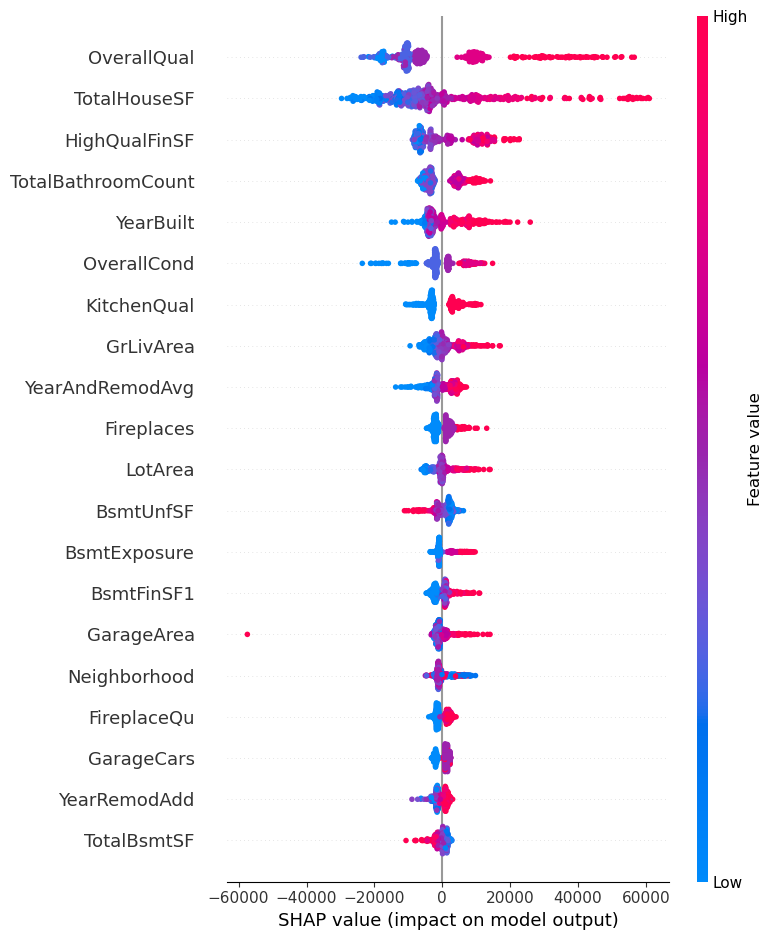

In [257]:
import shap

# Use the SHAP explainer
explainer = shap.Explainer(best_model)

# Calculate SHAP values for a subset of the data (e.g., test set)
shap_values = explainer.shap_values(X_test)

# Plot summary plot
shap.summary_plot(shap_values, X_test)

In [254]:
masterScores

,Model,r2_5kf_mean,rmse_5kf_mean
0,xgboost,0.905693,20536.208370
1,xgboost_tuned,0.922497,18420.933118


In [256]:
output_file = 'masterScores_xgboost.csv'

masterScores.to_csv(output_file, index=False, mode='w')

print(f"DataFrame exported to '{output_file}' in the same working directory.")

DataFrame exported to 'masterScores_xgboost.csv' in the same working directory.
